## Non-variational fixed-depth Hamiltonian simulation

Here we reproduce the the main demonstration example of "Fixed-depth Hamiltonian simulation via Cartan decomposition"
with our recursive KAK decomposition tool.

In [1]:
import pennylane as qml
import numpy as np
from itertools import combinations, product
from functools import partial
from pennylane import X, Y, Z, I
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
np.random.seed(2415)
from kak_tools import map_simple_to_irrep, map_irrep_to_matrices, identify_algebra, split_pauli_algebra, bdi, lie_closure_pauli_words, recursive_bdi, map_recursive_decomp_to_reducible, map_matrix_to_reducible

We begin by defining the Pauli words in the Hamiltonian 

$
H = \sum_{j=1}^{n-1} \alpha_j X_j X_{j+1} + \beta_j Y_j Y_{j+1} + \sum_{j=1}^n \gamma_j Z_j
$

and computing their Lie closure. We obtain a reducible representation of $\mathfrak{so}(2n)$ on $\mathbb{C}^{2^n}$.

In [2]:
n = 4 # Number of qubits

# Hamiltonian terms
generators = [X(w) @ X(w+1) for w in range(n-1)] + [Y(w) @ Y(w+1) for w in range(n-1)] + [Z(w) for w in range(n)]
# Map from general qml.operation.Operator instances to qml.pauli.PauliWord instances
generators = [next(iter(op.pauli_rep)) for op in generators]

# Compute Hamiltonian Lie algebra
algebra = lie_closure_pauli_words(generators, verbose=False)

# Compare algebra size to expected size of so(2n)
n_so = 2 * n # The "n" in so(n)
so_dim = (n_so**2-n_so) // 2

print(f"Hamiltonian algebra on {n} qubits with size {len(algebra)}; expected size is {so_dim}")

Hamiltonian algebra on 4 qubits with size 28; expected size is 28


Next, we map this irreducible representation to an irreducible representation on $\mathbb{R}^{2n}$,
by creating a `mapping` of each Pauli word to a basis element $F_{ij} = E_{ij} - E_{ji}$, where $E_{ij}$ is the real $2n \times 2n$ matrix with a $1$
at position $(i, j)$ and zeros else (we will use zero-based indexing). This mapping does not contain the signs required to make it an algebra homomorphism,
but we compute them in a separate lookup table `signs`.

We have one more requirement for this mapping, though:
The Pauli words from $H$ stored in `generators` are horizontal with respect to an involution on the reducible representation.
In order to use the KAK theorem for the mapping of $H$, we need to make sure that these generators are mapped to basis elements that
are horizontal with respect to the involution on the irreducible representation of the same type.
We will use an involution of type BDI and in the irreducible representation, we choose the canonical form of the involution

$
\theta(x) = I_{n, n} x I_{n, n} \text{ with } I_{n, n} = \operatorname{diag}(\underset{\times n}{\underbrace{1, \cdots, 1}}, \underset{\times n}{\underbrace{-1, \cdots, -1}}).
$

The basis elements $F_{ij}$ above are eigenstates of this involution, and the horizontal (eigenvalue $-1$) elements are those with $i<n$ and $j\geq n$:

$$
\theta(F_{ij}) 
= \delta_{k\ell} (\lambda(k<n) - \lambda(k>=n)) (E_{ij} - E_{ji})_{\ell m} \delta_{mp} (\lambda(m<n) - \lambda(m>=n))
= (-1)^{i>n} (-1)^{j>n} F_{ij} 
$$

We therefore make sure to map the Hamiltonian Pauli words to such elements with $i<n$ and $j\geq n$, by passing `generators` to `map_simple_to_irrep`
and the involution type `"BDI"`.

In [3]:
mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=generators, n=n_so, invol_type="BDI")

This mapping can now be used to create dense matrices in the irreducible representation:

In [4]:
matrix_map = map_irrep_to_matrices(mapping, signs, n_so, invol_type="BDI")

In [5]:
# from pennylane.labs.dla import structure_constants_dense
# adj_dense = structure_constants_dense([matrix_map[op]/1j for op in algebra], is_orthonormal=False)
# adj = qml.pauli.dla.structure_constants(algebra, pauli=True)
# print(np.allclose(np.abs(adj), np.abs(adj_dense)))
# print(np.allclose(np.sign(adj), np.sign(adj_dense)))
# print(np.allclose(adj, adj_dense))
# print(np.unique(adj_dense), np.unique(adj))

Now we can map individual Pauli operators to basis elements $F_{ij}$ in a homomorphic manner:

In [6]:
op1, op2 = algebra[0], algebra[n]
# Compute operator commutator, taking imaginary unit into account
ops_com = (qml.commutator(1j * op1, 1j * op2) / 1j).pauli_rep
# Make sure the commutator really is just a rescaled Pauli word
assert len(ops_com) == 1
# Extract Pauli word and scalar prefactor from operator commutator
[(ops_com_pw, ops_com_prefactor)] = ops_com.items()
# Map the Pauli word to irreducible basis element and include scalar prefactor
commutator_from_ops = matrix_map[ops_com_pw] * ops_com_prefactor

# Map the original operators to matrices directly and compute the matrix commutator
mat1, mat2 = matrix_map[op1], matrix_map[op2]
commutator_from_mats = mat1 @ mat2 - mat2 @ mat1

# Check whether the commutators agree
print(np.allclose(commutator_from_ops, commutator_from_mats))

True


Here we had to take into account that we store Pauli words in `algebra` but mathematically, the algebra consists of Pauli words multiplied
by the imaginary unit.

Next, we can construct the Hamiltonian operator in the irreducible representation. For this, we map the Hamiltonian generators to matrices and
combine them with coefficients $\alpha$, $\beta$, $\gamma$.

In [7]:
alphas = np.random.normal(0.6, 1., size=n-1)
betas = np.random.normal(0.3, 1.2, size=n-1)
gammas = np.random.normal(0.8, 1., size=n)
coeffs = np.concatenate([alphas, betas, gammas])
# coeffs = np.eye(3*n-2)[0] * 1e-2
print(coeffs)
H = qml.dot(coeffs, generators)
terms_irrep = np.stack([matrix_map[gen] for gen in generators])
H_irrep = np.tensordot(coeffs, terms_irrep, axes=[[0], [0]])
assert np.allclose(H_irrep.imag, 0.)
H_irrep = H_irrep.real
print(np.round(H_irrep, 5))

[ 0.04640841 -1.56441295 -1.176317   -0.21070431  2.09263452  1.20736717
  1.38906848 -0.5687223   0.81170077  0.09196967]
[[ 0.       0.       0.       0.       0.09282  0.      -1.13744  4.18527]
 [ 0.       0.       0.       0.       0.      -2.41473 -3.12883  1.6234 ]
 [ 0.       0.       0.       0.       0.       0.18394  0.       2.35263]
 [ 0.       0.       0.       0.      -2.77814  0.       0.42141  0.     ]
 [-0.09282  0.       0.       2.77814  0.       0.       0.       0.     ]
 [ 0.       2.41473 -0.18394  0.       0.       0.       0.       0.     ]
 [ 1.13744  3.12883  0.      -0.42141  0.       0.       0.       0.     ]
 [-4.18527 -1.6234  -2.35263  0.       0.       0.       0.       0.     ]]


Now we can move on to the KAK decomposition. For this we create an "exemplary" time evolution operator
$\exp(-itH)$ with, say, $t=1$. Note that we will not have to include the imaginary unit here, because the implemented matrix is an _algebra_ element, so that `H_irrep` already corresponds to $iH$. As we are moving in the irreducible representation of $\mathfrak{so}(2n)=\mathfrak{so}(32)$ here, `H_irrep` and the time evolution operator are just real $32 \times 32$ matrices.

In [8]:
time = 0.01
U = expm(time * H_irrep)
print(U.shape, n_so)

(8, 8) 8


Then we apply our recursive BDI KAK decomposition to the time evolution operator, which will decompose the vertical operators in each step until we arrive at matrices of the form

$
\left(\begin{array}{cccc}
    \cos(a) & -\sin(a) & 0 & 0 \\
    \sin(a) & \cos(a) & 0 & 0 \\
    0 & 0 & \cos(b) & -\sin(b) \\
    0 & 0 & \sin(b) & \cos(b)
\end{array}\right),
$

corresponding to the operation $\exp(-i(aP_1+bP_2))$ where $P_1$ ($P_2$)is the Pauli word mapped to the basis element $F_{ij}$ matching the entry $-\sin(a)$ ($-\sin(b)$) in the matrix above. In particular, because those basis elements commute, $P_1$ and $P_2$ will, too, allowing us to pull the exponential apart into individual Pauli rotations, $\exp(-iaP_1)\exp(-ibP_2)$.

In [9]:
recursive_decomp = recursive_bdi(U, n_so)
num_iter = max(recursive_decomp.keys())

To arrive at a circuit that can be implemented in terms of Pauli rotation, we need to map back to the reducible representation.
This is done by the following function:

In [10]:
pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, "BDI", time=time, assertions=True)

In [11]:
np.cos(3.307582192828685*2)

np.float64(0.9453991846578179)

In [12]:
def all_commuting(pws1, pws2):
    for pw1, pw2 in product(pws1, pws2):
        if not pw1.commutes_with(pw2):
            return False
    return True

pws_from_pauli_decomp = [pw for pw, *_ in pauli_decomp]
assert all_commuting(pws_from_pauli_decomp[:6], pws_from_pauli_decomp[6:12])
assert all_commuting(pws_from_pauli_decomp[12:16], pws_from_pauli_decomp[12:16])
assert all_commuting(pws_from_pauli_decomp[16:22], pws_from_pauli_decomp[22:28])     
        

In [13]:
postproc = []
for pauli_word, coeff, t in pauli_decomp:
    assert np.isclose(coeff.imag, 0.), f"{coeff}"
    postproc.append((coeff.real, qml.pauli.pauli_word_to_string(pauli_word), pauli_word.wires, t))
    # print(pauli_word, qml.pauli.pauli_word_to_string(pauli_word), pauli_word.wires)
print(*postproc, sep="\n")

(np.float64(0.1838043394186198), 'YX', Wires([1, 2]), 'k')
(np.float64(-1.4048067875560046), 'ZXZY', Wires([2, 3, 1, 0]), 'k')
(np.float64(1.082832539443198), 'ZXY', Wires([2, 3, 1]), 'a')
(np.float64(-0.6885984987865787), 'ZXY', Wires([1, 2, 0]), 'a')
(np.float64(1.7256976077613042), 'YX', Wires([1, 2]), 'k')
(np.float64(-0.2854716384461145), 'ZXZY', Wires([2, 3, 1, 0]), 'k')
(np.float64(1.4151920594991383), 'ZZYX', Wires([1, 2, 3, 0]), 'k')
(np.float64(-2.242222908342436), 'XY', Wires([1, 2]), 'k')
(np.float64(-0.021306389455873147), 'XY', Wires([0, 1]), 'a')
(np.float64(-0.3621011134654315), 'XY', Wires([2, 3]), 'a')
(np.float64(-0.7179619004358074), 'ZZYX', Wires([1, 2, 3, 0]), 'k')
(np.float64(-0.5939522359438973), 'XY', Wires([1, 2]), 'k')
(np.float64(-0.11762436608993762), 'XX', Wires([0, 1]), 'a0')
(np.float64(-1.382915028979158), 'YY', Wires([2, 3]), 'a0')
(np.float64(1.6163911638927486), 'ZXX', Wires([2, 3, 1]), 'a0')
(np.float64(2.845307948388316), 'YZY', Wires([0, 1, 2]), '

In [14]:
print(*recursive_decomp[0], sep="\n")

(array([[ 0.51914291,  0.09358372,  0.45970899,  0.71442311,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.13707549, -0.23239197, -0.74533876,  0.60965105,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.84323031,  0.06588645,  0.41188416,  0.33907677,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.02576045, -0.96586491,  0.25197065, -0.05433376,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0993878 ,
         0.97330317, -0.20333576,  0.03817814],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.74770924,
         0.20727376,  0.58016798, -0.24773694],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.64083359,
         0.07724406,  0.59246931, -0.48202259],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.14277699,
         0.06125259,  0.52061482,  0.83953741]]), 0, 8, 'k')
(array([[ 0.999997

In [15]:
len(postproc)

28

In [16]:
if n == 2:
    assert len(postproc) == len(pauli_decomp) == 6
    splits = [2, 4, 6]
elif n== 4:
    assert len(postproc) == len(pauli_decomp) == 28
    splits = [12, 16, 28]
elif n== 8:
    assert len(postproc) == len(pauli_decomp) == 120
    splits = [56, 64, 120]

K_1 = np.eye(2**n, dtype="complex")
for coeff, pauli_str, wires, t in postproc[:splits[0]]:
    assert t in "ak"
    K_1 = K_1 @ qml.matrix(qml.PauliRot(-2 * coeff, pauli_word=pauli_str, wires=wires), wire_order=range(n))
    print("".join([pauli_str[wires.index(w)] if w in wires else "I" for w in range(n)]))

K_2 = np.eye(2**n, dtype="complex")
for coeff, pauli_str, wires, t in postproc[splits[1]:splits[2]]:
    assert t in "ak"
    K_2 = K_2 @ qml.matrix(qml.PauliRot(-2 * coeff, pauli_word=pauli_str, wires=wires), wire_order=range(n))

a = 0
a_irrep = 0
for pauli_word, coeff, t in pauli_decomp[splits[0]:splits[1]]:
    assert t=="a0"
    a = a + pauli_word * coeff
    a_irrep = a_irrep + matrix_map[pauli_word] * coeff


U_rec = np.eye(2*n)
        
for pauli_word, coeff, t in pauli_decomp:
    print(pauli_word, coeff, t)
    T = time if t=="a0" else 1.
    print(expm(matrix_map[pauli_word] * coeff * T))
    U_rec = U_rec @ expm(matrix_map[pauli_word] * coeff * T)

for th in recursive_decomp[0]:
    print(th)

assert np.allclose(expm(time * H_irrep), U_rec)

a_mat = qml.matrix(a, wire_order=range(n))
H_mat = qml.matrix(H, wire_order=range(n))
a_eigvals = qml.eigvals(a.operation())
H_eigvals = qml.eigvals(H)
# print(np.exp(1j * a_eigvals), np.exp(1j * H_eigvals))
print((a_eigvals, H_eigvals))
# print(a_eigvals[1]-a_eigvals[0])
# print(H_eigvals[1]-H_eigvals[0])
# print(a_eigvals[0]-H_eigvals[0])
assert np.allclose(a_eigvals, H_eigvals)


A = np.eye(2**n, dtype="complex")
for coeff, pauli_str, wires, t in postproc[splits[0]:splits[1]]:
    assert t == "a0"
    A = A @ qml.matrix(qml.PauliRot(-2 * coeff, pauli_word=pauli_str, wires=wires), wire_order=range(n))
    print("".join([pauli_str[wires.index(w)] if w in wires else "I" for w in range(n)]))

assert np.allclose(expm(1j * a_mat), A)
assert np.allclose(K_1 @ K_1.conj().T, np.eye(2**n))
assert np.allclose(K_2 @ K_2.conj().T, np.eye(2**n))
print(np.allclose(K_1, K_2.conj().T), np.allclose(K_1, K_2))
assert np.allclose(recursive_decomp[0][0][0], recursive_decomp[0][2][0].T)
assert np.allclose(recursive_decomp[0][0][0] @ recursive_decomp[0][1][0] @ recursive_decomp[0][2][0], U)
# assert np.allclose(np.linalg.multi_dot([entry[0] for entry in recursive_decomp[1][:6]]), recursive_decomp[0][0][0])
# assert np.allclose(recursive_decomp[1][6][0], recursive_decomp[0][1][0])
# assert np.allclose(np.linalg.multi_dot([entry[0] for entry in recursive_decomp[1][7:13]]), recursive_decomp[0][2][0])
for _iter in range(max(recursive_decomp.keys())):
    assert all(entry[0].shape==(n_so, n_so) for entry in recursive_decomp[_iter])

H_from_H_irrep = map_matrix_to_reducible(H_irrep, mapping, signs, "BDI")
assert np.allclose(qml.matrix(H_from_H_irrep, wire_order=range(n)), H_mat)
print(np.allclose(recursive_decomp[0][0][0] @ a_irrep @ recursive_decomp[0][2][0], H_irrep))
print(np.allclose(K_1 @ a_mat @ K_2, H_mat))
print(np.round(K_1 @ a_mat @ K_2, 5))
print(np.round(H_mat, 5))
print(np.allclose(K_1 @ a_mat @ K_1.conj().T, H_mat))

IYXI
YZZX
IYZX
YZXI
IYXI
YZZX
XZZY
IXYI
XYII
IIXY
XZZY
IXYI
Y(1) @ X(2) 0.1838043394186198 k
[[ 0.93318942  0.35938491  0.          0.          0.          0.
   0.          0.        ]
 [-0.35938491  0.93318942  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]
Z(2) @ X(3) @ Z(1) @ Y(0) -1.4048067875560046 k
[[ 1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.    

In [17]:
print(np.round(K_1, 4))
print(np.round(K_2, 4))
print()
print(recursive_decomp[0][0][0])
print(recursive_decomp[0][2][0])

[[ 0.3711+0.j  0.    -0.j  0.    +0.j  0.4609+0.j  0.    +0.j -0.0324+0.j
  -0.0199+0.j  0.    +0.j  0.    -0.j -0.0151+0.j -0.1603+0.j  0.    +0.j
   0.5012+0.j  0.    -0.j  0.    -0.j  0.6093+0.j]
 [ 0.    -0.j  0.161 +0.j -0.1278+0.j  0.    -0.j  0.1576+0.j  0.    +0.j
   0.    +0.j  0.176 +0.j -0.5317+0.j  0.    -0.j  0.    +0.j -0.7351+0.j
   0.    +0.j  0.2703+0.j -0.076 +0.j  0.    -0.j]
 [ 0.    -0.j -0.379 +0.j  0.3523+0.j  0.    -0.j -0.2834+0.j  0.    -0.j
   0.    +0.j -0.301 +0.j -0.3435+0.j  0.    +0.j  0.    -0.j -0.2485+0.j
   0.    +0.j -0.4933+0.j  0.3718+0.j  0.    +0.j]
 [ 0.2554+0.j  0.    -0.j  0.    -0.j  0.3396+0.j  0.    +0.j  0.0157+0.j
  -0.0657+0.j  0.    +0.j  0.    +0.j -0.7023+0.j  0.5127+0.j  0.    -0.j
  -0.207 +0.j  0.    +0.j  0.    -0.j -0.126 +0.j]
 [ 0.    +0.j -0.2413+0.j  0.0523+0.j  0.    +0.j  0.534 +0.j  0.    +0.j
   0.    +0.j  0.6807+0.j -0.017 +0.j  0.    +0.j  0.    +0.j  0.0853+0.j
   0.    +0.j -0.3027+0.j  0.3022+0.j  0.    +0.j]
 [-0.

With this decomposition in our hands, we can construct a circuit implementing the time evolution operator. For
this we implement a convenience function that maps from our Pauli word output to `PauliRot` gates.
It also takes into account that for a flexible-time evolution operator $\exp(-itH)$ with $t$ other than $1$, the central
CSA element needs to be rescaled by $t$.

In [18]:
def pauli_rot(coeff, pauli_str, wires, t, time):
    if t == "a0":
        coeff = coeff * time
    qml.PauliRot(-2 * coeff, pauli_word=pauli_str, wires=wires)

In [19]:
def time_evolution(time):
    for pauli_term in postproc[::-1]:
        pauli_rot(*pauli_term, time)

obs = Z(0)
dev = qml.device("lightning.qubit", wires=n)
dev_def = qml.device("default.qubit", wires=n)

@qml.qnode(dev, grad_on_execution=False)
def kak_circuit(time):
    qml.X(0)
    time_evolution(-time)
    return qml.expval(obs)

H_red = qml.dot(coeffs, generators)
H_red_ps = H_red.pauli_rep
H_red_ps.simplify()
H_red_rec = map_matrix_to_reducible(H_irrep, mapping, signs, "BDI")
H_red_rec.simplify()
assert set(H_red_ps) == set(H_red_rec)
for k in H_red_ps:
    assert np.isclose(H_red_ps[k], H_red_rec[k])

from pennylane.devices.default_qubit import stopping_condition as sc_def

def stopping_condition(obj):
    return sc_def(obj) and not isinstance(obj, qml.ops.Exp)

@partial(qml.devices.preprocess.decompose, stopping_condition=stopping_condition)
@qml.qnode(dev, grad_on_execution=False)
def trotter_circuit(time, num_steps):
    qml.X(0)
    qml.exp(-1j * time * H_red, num_steps=num_steps)
    return qml.expval(obs)

@qml.qnode(dev_def, interface="jax", grad_on_execution=False)
def exact_circuit(time):
    qml.X(0)
    qml.exp(-1j * time * H_red)
    return qml.expval(obs)

In [20]:
times = np.linspace(0, 1, 200)
all_num_steps = [2, 5, 10, 20, 100]
kak_out = jax.vmap(kak_circuit, in_axes=0)(times)

In [21]:
exact_out = jax.vmap(exact_circuit, in_axes=0)(times)

In [22]:
trotter_out = [
    jax.vmap(partial(trotter_circuit, num_steps=ns), in_axes=0)(times)
    for ns in all_num_steps
]

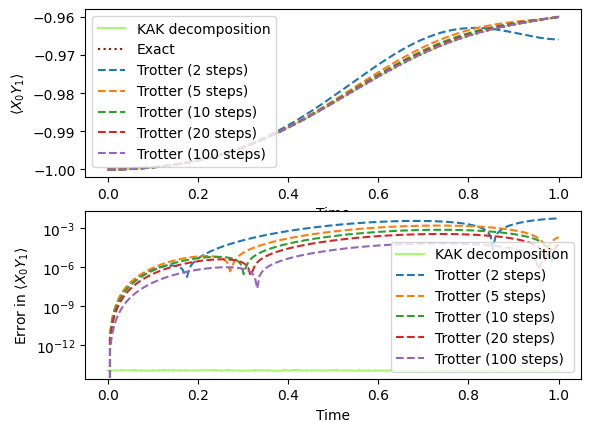

In [23]:
fig, axs = plt.subplots(2, 1)
ax = axs[0]
ax.plot(times, kak_out, label="KAK decomposition", color="xkcd:spring green")
ax.plot(times, exact_out, label="Exact", color="xkcd:brick red", ls=":")
for ns, out in zip(all_num_steps, trotter_out):
    ax.plot(times, out, label=f"Trotter ({ns} steps)", ls="--")
ax.legend()
ax.set_ylabel("$\\langle X_0Y_1\\rangle$")
ax.set_xlabel("Time")

ax = axs[1]
ax.plot(times, np.abs(kak_out-exact_out), label="KAK decomposition", color="xkcd:spring green")
for ns, out in zip(all_num_steps, trotter_out):
    ax.plot(times, np.abs(out-exact_out), label=f"Trotter ({ns} steps)", ls="--")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Error in $\\langle X_0Y_1\\rangle$")
ax.set_xlabel("Time");


In [24]:
def get_paulirot_count(qnode):
    var_types = {"PauliRot", "IsingXX", "IsingYY", "RZ"}
    def wrapper(*args, **kwargs):
        specs = qml.specs(qnode)(*args, **kwargs)
        gate_count = specs['resources'].num_gates
        gate_types = specs['resources'].gate_types
        assert set(gate_types).issubset(var_types | {"PauliX"}), f"{gate_types}"
        assert gate_types["PauliX"] == 1
        var_gate_count = 0
        for t in var_types:
            var_gate_count += gate_types.get(t, 0) 
        assert gate_count == var_gate_count + 1
        return var_gate_count
    return wrapper

print(get_paulirot_count(kak_circuit)(times[-1]))
for ns in all_num_steps:
    print(get_paulirot_count(trotter_circuit)(times[-1], num_steps=ns))

28
20
50
100
200
1000


In [25]:
op0 = algebra[n]
print(op0)
mat0 = matrix_map[op0]
from kak_tools import map_matrix_to_reducible, group_matrix_to_reducible
map_matrix_to_reducible(mat0, mapping, signs, "BDI")

Y(1) @ Y(2)


1.0 * Y(1) @ Y(2)

In [26]:
c1 = np.random.random(len(algebra))
op1 = qml.dot(c1, algebra).pauli_rep
mat1 = np.tensordot(c1, [matrix_map[op] for op in algebra], axes=[[0], [0]])
# u1 = expm(mat1)
# op1_out = group_matrix_to_reducible(u1, mapping, signs, "BDI").pauli_rep
op1_out = map_matrix_to_reducible(mat1, mapping, signs, "BDI").pauli_rep
assert set(op1_out) == set(op1), f"{set(op1_out)}\n{set(op1)}"
for k in op1:
    assert np.isclose(op1_out[k], op1[k]), f"{op1_out[k]}, {op1[k]}"

In [27]:
time = 0.613
op2 = algebra[n]
print(op2)
mat2 = matrix_map[op2]
gmat2 = expm(-time * mat2)
from kak_tools import group_matrix_to_reducible
group_matrix_to_reducible(gmat2, mapping, signs, "BDI") / (-time)

Y(1) @ Y(2)


1.0 * Y(1) @ Y(2)

In [28]:
com_set = [algebra[0], algebra[n//2], algebra[n-1]]
for a, b in combinations(com_set, r=2):
    assert a.commutes_with(b)
c3 = np.random.random(len(com_set))
op3 = qml.dot(c3, com_set).pauli_rep
mat3 = np.tensordot(c3, [matrix_map[op] for op in com_set], axes=[[0], [0]])
gmat3 = expm(-time * mat3)
op3_out = group_matrix_to_reducible(gmat3, mapping, signs, "BDI") / (-time)
op3_out.simplify()

print(op3)
print(op3_out)
# for pw, val in op3_out.items():
#     print(pw, val)
reconstruct_mat3 = np.sum([val.real * matrix_map[pw] for pw, val in op3_out.items()], axis=0)
assert np.allclose(expm(-time * reconstruct_mat3), gmat3), f"\n{expm(-time * reconstruct_mat3)}\n{gmat3}"

assert set(op3_out) == set(op3), f"{set(op3_out)}\n{set(op3)}"
op_mat3 = qml.matrix(op3, wire_order=range(n))
op_mat3_out = qml.matrix(op3_out, wire_order=range(n))
for k in op3:
    assert np.isclose(op3_out[k], op3[k]), f"{expm(op_mat3-op_mat3_out)}"
#f"{np.divide(op_mat3, op_mat3_out, out=np.ones_like(op_mat3), where=np.abs(op_mat3_out)>1e-15)}"

0.9728894937978185 * X(0) @ X(1)
+ 0.3611337818796375 * X(2) @ X(3)
+ 0.47352332349683013 * Y(0) @ Y(1)
0.9728894937978186 * X(0) @ X(1)
+ 0.36113378187963757 * X(2) @ X(3)
+ 0.47352332349683013 * Y(0) @ Y(1)


In [29]:
# Check that products are compatible with representations
def matrix(op):
    return qml.matrix(op, wire_order=range(n))

op1 = algebra[0]
op2 = algebra[n]
c1, c2 = 0.63, -0.215
assert not op1.commutes_with(op2)
exp_prod_red = qml.pauli_decompose(logm(expm(1j * matrix(op1) * c1) @ expm(1j * matrix(op2) * c2))/1j)
print(type(exp_prod_red))
print(exp_prod_red)

expm(matrix_map[op1] * c1) @ expm(matrix_map[op2] * c2)

<class 'pennylane.ops.op_math.linear_combination.LinearCombination'>
-0.1856117729676488 * (I(0) @ Y(1) @ Y(2) @ I(3)) + 0.6197236199842698 * (X(0) @ X(1) @ I(2) @ I(3)) + 0.13533227759124344 * (X(0) @ Z(1) @ Y(2) @ I(3))


array([[ 0.2779771 ,  0.        ,  0.        ,  0.        ,  0.95209034,
         0.        ,  0.        , -0.12748614],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.86541751,  0.        ,  0.        ,  0.        ,  0.30581691,
         0.        ,  0.        ,  0.39689866],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 0.4168708 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.90896575]])

In [30]:
# time = 0.6
# # U = expm(-time * H)

# ops = recursive_bdi(U, n_so, num_iter=None)
# num_iter = max(ops.keys())

# widths = [e-s for _, s, e, _ in ops[num_iter]]
# widths, counts = np.unique(widths, return_counts=True)
# widths_dict = dict(zip(map(int, widths), map(int, counts)))
    
# print(f"Decomposed into {len(ops[num_iter])} blocks with (partially large) CSA blocks and K blocks with sizes\n{widths_dict}")

# num_paulirots = 0
# for op, s, e, t in ops[num_iter]:
#     if e - s > 4:
#         assert t.startswith("a")
#     num_paulirots += (e - s) // 2

# print(f"This decomposition consists of {num_paulirots} individual Pauli rotations")

# def num_ops(_iter):
#     if _iter==0:
#         return 3
#     return num_ops(_iter - 1) + 4 ** _iter * 5 // 2

# # Validate
# for i in range(num_iter+1):
#     print(f"{i=}")
#     print(f"{len(ops[i])}, {num_ops(i)}")
#     assert len(ops[i]) == num_ops(i), f"{len(ops[i])}, {num_ops(i)}"
#     for tup in ops[i]:
#         assert isinstance(tup, tuple) and len(tup) == 4
#         assert isinstance(tup[0], np.ndarray) and tup[0].shape == (n_so, n_so)
#         for val in tup[1:3]:
#             assert isinstance(val, int) and 0<=val<=n_so
#         assert tup[3] in {"a", "k", "a0"}

#     pos = 0
#     if i > 0:
#         for j in range(len(ops[i-1])):
#             if ops[i-1][j][3] == "k":
#                 rec = ops[i][pos][0] @ ops[i][pos+1][0] @ ops[i][pos+2][0] @ ops[i][pos+3][0] @ ops[i][pos+4][0] @ ops[i][pos+5][0]
#                 assert np.allclose(rec, ops[i-1][j][0])
#                 pos += 6
#             else:
#                 assert ops[i-1][j][3].startswith("a")
#                 assert np.allclose(ops[i][pos][0], ops[i-1][j][0])
#                 pos += 1